In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 2,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.0,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [3]:
query = "SELECT TOP 10000 \
phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source \
WHERE parallax_over_error > 20 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

In [4]:
wd_query = "SELECT TOP 1000 \
phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source \
WHERE parallax_over_error > 20 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND bp_rp < 2 \
AND phot_g_mean_mag+5*log10(parallax)-10 > 10+2.6*bp_rp"

In [5]:
from astroquery.gaia import Gaia
job = Gaia.launch_job(wd_query)
data = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


(17, -2)

/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


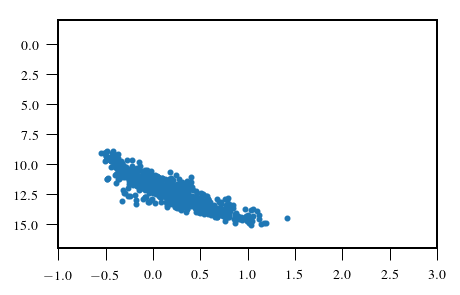

In [6]:
fig, ax1 = plt.subplots()
ax1.scatter(data['bp_rp'], data['mg'])
ax1.set_xlim([-1,3])
ax1.set_ylim([17,-2])

In [7]:
pulsar_data = np.genfromtxt('ipta_3arcsec_wpm-result.csv', 
                            delimiter=',', names=True, dtype=None, encoding=None)

In [8]:
from astropy.table import Table, unique
pulsar_data = Table(pulsar_data)
pulsar_data.sort(['names', 'angdist'])
pulsar_data = unique(pulsar_data, keys='names') # drop less-good duplicate matches

In [9]:
names_keep = ['J0437-4715', 'J1012+5307', 'J1024-0719', 'J1732-5049', 'J1910+1256', 'J1955+2908']
pulsar_data = pulsar_data[np.isin(pulsar_data['names'], names_keep)] # keep only the sources we wrote about

In [10]:
pulsar_data['mg'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['r_est']/1.e3) - 5.
pulsar_data['mg_lo'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['r_hi']/1.e3) - 5.
pulsar_data['mg_hi'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['r_lo']/1.e3) - 5.

In [11]:
mg_err = np.vstack((np.abs(pulsar_data['mg_lo'] - pulsar_data['mg']), 
                    np.abs(pulsar_data['mg_hi'] - pulsar_data['mg'])))

In [27]:
pulsar_data['names', 'bp_rp','mg']

names,bp_rp,mg
str11,float64,float64
J0437-4715,1.5482254,19.993852577575694
J1012+5307,0.27422142,15.295923033080037
J1024-0719,1.8346329,13.660346326324227
J1732-5049,1.0322933,12.892276783218502
J1910+1256,1.3901577,12.774463772247447
J1955+2908,2.9197636,12.509740243102563


In [81]:
import matplotlib.patheffects as path_effects


/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


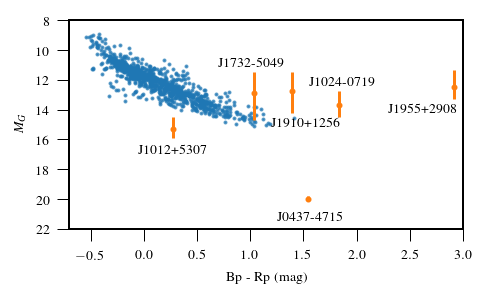

In [128]:
fig, ax1 = plt.subplots()
ax1.scatter(data['bp_rp'], data['mg'], color='C0', alpha=0.7, s=1)
ax1.errorbar(pulsar_data['bp_rp'], pulsar_data['mg'], yerr=mg_err, color='C1', fmt='o')
ax1.set_xlim([-.7,3])
ax1.set_ylim([22,8])
ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')
#for ii in range(6):
#    ax1.annotate(pulsar_data['names'][ii], (data['bp_rp'][ii], data['mg'][ii]), color = 'black')
ax1.annotate(pulsar_data['names'][0], (1.25, 21.5), color = 'black')
ax1.annotate(pulsar_data['names'][1], (-.05, 17), color = 'black')
ax1.annotate(pulsar_data['names'][2], (1.55,12.5), color = 'black')
ax1.text(0.7, 11.2, pulsar_data['names'][3], color = 'black', weight = 'heavy')
#text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'),
#                       path_effects.Normal()])
ax1.annotate(pulsar_data['names'][4], (1.2,15.2), color = 'black')
ax1.annotate(pulsar_data['names'][5], (2.3, 14.3), color = 'black')



plt.tight_layout()
plt.savefig("../figures/hrd_wLabels.pdf")

In [13]:
pulsar_data['bp_rp']

1.5482254
0.27422142
1.8346329
1.0322933
1.3901577
2.9197636


In [14]:
pulsar_data['mg']

19.993852577575694
15.295923033080037
13.660346326324227
12.892276783218502
12.774463772247447
12.509740243102563


In [15]:
mg_err

array([[0.19127389, 0.8051767 , 0.93210953, 1.41544365, 1.27773926,
        1.16976828],
       [0.17620295, 0.63053132, 0.81358984, 1.79136568, 1.43815823,
        0.80025377]])